In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
from gensim import corpora, models
from gensim.models import word2vec
import xgboost as xgb 
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD

/home/digitman/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/digitman/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/digitman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/digitman/a

# Loading data

In [3]:
data = pd.read_csv('data/comments_vrn.csv.gz')

In [4]:
data.shape

(185612, 6)

In [5]:
data.is_gum.value_counts()

0.0    98373
1.0    87239
Name: is_gum, dtype: int64

In [8]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,9048238,Вжух даже здесь,0.0,20,1,2
1,9048238,И пишите аккуратнее 😞,0.0,12,3,2
2,9048238,Это #имбрина 😏,0.0,21,0,2


# Preprocessing

## Words count

In [9]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [10]:
lenghts_word.mean(), np.median(lenghts_word)

(11.451069973924099, 7.0)

In [11]:
comments = data[(lenghts_word < 50) & (lenghts_word > 4)]
comments.shape

(114275, 6)

## Links

In [12]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.54% of comments contain links


In [13]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True
                for c in comments.text.values] 

In [14]:
comments = comments[without_link]

In [15]:
comments.shape

(113709, 6)

# Droping outliers

In [16]:
from sklearn.ensemble import IsolationForest

In [17]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2), analyzer='word', max_df=0.6)
X = vectorizer.fit_transform([' '.join(t.split()[:5]) for t in comments.text.values])
y = comments.is_gum.values
# y = comments.sex.values

In [18]:
vectorizer = CountVectorizer(max_features=1000, ngram_range=(3, 3), analyzer='char')
X = vectorizer.fit_transform([' '.join(t.split()[:4]) for t in comments.text.values])
y = comments.is_gum.values
# y = comments.sex.values

In [19]:
forest = IsolationForest(200, contamination=0.01, n_jobs=-1)
forest.fit(X)
X_pred = forest.predict(X)
comments['len'] = [len(t) for t in comments.text.values]
comments['outlier'] = X_pred

In [20]:
comments[comments.outlier == -1].head(10).text.values

array([ '[id77046083|Виктор], кстати, тут никаких проблем нет. Снизу слева. Если смотреть с Земли.',
       '[id254300877|Виктория], именно! Только не знают об этом.',
       '[id254300877|Виктория], которого божества? Никто не хамит в сторону истинного Бога, Летающего и Макаронного!',
       '[id6628178|Сергей], о, интересно. Для планового уничтожения вначале надо провести обнаружение. Неужто руки дошли?! Честно говоря, слабо себе представляю...',
       '[id59044595|Алексей], кстати сказать, я диаметрально изменил свое отношение к РПЦ за последние 10 лет. Начнем с того, что в первой половине 90-х я крестился. Теперь же я бы с удовольствием взорвал храм Лужка Строителя еще раз.',
       '[id59044595|Алексей], правильно. Верно. Для меня свят разум. Почему я должен молчать, когда его попирают?',
       '[id102189842|Мария], Да пусть высказываться... Он не удачник просто жаль его... А тут он себя просто показывает чтоб его заметили 😂😂😂но он не стоит ваших нервов забейте на него 👍👍👍',
   

In [21]:
comments.groupby('outlier').mean()

,from_id,is_gum,hour,likes,sex,len
outlier,,,,,,
-1,1.003984e+08,0.494728,11.980668,0.467487,1.660808,108.568541
1,9.166110e+07,0.461940,12.739027,1.073891,1.701993,88.377273


## Emoji

In [22]:
comments_list = comments.text.values

In [23]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [24]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [25]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [26]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

#### If not done before

In [20]:
len(comments_list)

113709

In [ ]:
# %time emoji_from_comments_rep = list(map(get_emoji, comments_list))

In [ ]:
with open('emoji_from_comments_rep_vrn.pkl', 'wb') as f:
    pickle.dump(emoji_from_comments_rep, f)

#### Else load

In [27]:
with open('emoji_from_comments_rep_vrn.pkl', 'rb') as f:
    emoji_from_comments_rep = pickle.load(f)
emoji_from_comments_no_rep = list(map(lambda com: get_emoji(com, False), comments_list))
len(comments_list), len(emoji_from_comments_rep)

(113709, 113709)

In [28]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

In [29]:
em_proportion_rep = get_emoji_proportion(comments_list, emoji_from_comments_rep)
em_proportion_no_rep = get_emoji_proportion(comments_list, emoji_from_comments_no_rep)

### With repetition

In [30]:
print((em_proportion_rep > 0.2).sum())
comments_list[em_proportion_rep > 0.2][:10]

158


array(['👍👍👍👍👍👍клааас❗❗❗❗ эта елка будееет самой красивой😂😂😂😂',
       '😂😂😂😂👍👍👍н ну это ж люди....\n😂😂😂блин а когда новый год???😂',
       '😂😂😂😂😂😂вот бы меня на купюру не плохооо было б😂😂😂',
       'И здесь хорошо и там хорошо....👍👍👍👍👍👍👍👍👍',
       'Да что вы... Кому что нравится 😍😍😍😍👍👍👍👍👍👍👍👍',
       'А мне нравится можно вообще не работать 😂😂😂😂😂👍👍👍👍👍👍',
       '😍😍😍😍😍😍и тишина и спокойствие 👍👍👍👍👍',
       'Кому как но Воронеж это воронеж любим и будем любить 😍😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍',
       'А я отправлю :одумайся не глупи замуж не выходи 😂😂😂😂😂😂👍👍👍👍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻'], dtype=object)

### Without repetition

In [31]:
print((em_proportion_no_rep > 0.07).sum())
comments_list[em_proportion_no_rep > 0.07][:10]

285


array(['Главное чтоб не поздно 😂😂😂👍', '😂😂😂это я с Перми возвращаюсь 😍😍',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '😂😂😂😂😂это еще что такое 😂😂😂😂😂👍👍👍',
       '👍👍👍👍👍👍👍😍😍😍😍😍😍самый  лучший красивый город 😛😛😛',
       '😂😂😂😂😂👍👍👍👍👍вот те на царица прям', '😂😂😂😂😂👍👍👍👍а я так часто еду 😂😂😂',
       '😂😂😂😂а я ничего себе не скажу 👍👍👍',
       'С горем пополам... ❄  ❄  ❄  ❄  ❄  👍',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄'], dtype=object)

### Proportion of alphabetical symbols

In [32]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [33]:
abc_proportion = get_abc_proportion(comments_list)

In [34]:
sum(abc_proportion < 0.5)

549

In [35]:
comments_list[abc_proportion < 0.5][:10]

array(['+7 952 104 73 50', '[id33372525|Денис], а кто в 14)?',
       'Оооо подсолнухи 👍👍👍👍😍😍😍😍😍😍👍🌻 🌻 🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻🌻',
       '[id366133865|Андрей], у меня кот))) подойдет????? 😂😂😂😂',
       '[id330930820|Ляська], а у меня тоже.... 😂😂👍',
       '[id322876931|Андрей], 😂😂😂😂 вот блин 😂😂😂',
       '[id16867860|Дмитрий], но уж нет))) 😂😂😂😂',
       '[id42740602|Юлия], будут две 1, 22, 29, 38, 55 и 120А все платные.',
       '[id290551639|Vika], а у вас э',
       '[id138651229|Никита], И прям перед НГ! 🎄 🎄 🍻 🍻 🍷 🍷 ❄ ❄ ❄ ❄ ❄ ❄'], dtype=object)

### Filling DataFrame

In [36]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments_rep]
comments['em_proportion_rep'] = em_proportion_rep
comments['em_proportion_no_rep'] = em_proportion_no_rep
comments['abc_proportion'] = abc_proportion

In [37]:
comments.head(3)

,from_id,text,is_gum,hour,likes,sex,len,outlier,emojis,em_proportion_rep,em_proportion_no_rep,abc_proportion
6,9048238,"ну ппц, уже просто так телефон не зарядишь... 😆",0.0,22,4,2,47,1,😆,0.025641,0.025641,0.871795
7,10679122,"[id332962766|Игорь], они кагбэ намекают, что н...",0.0,20,0,2,101,1,,0.000000,0.000000,0.818182
8,10679122,"[id386347082|Jeg-Hater], просто вою! Бли-и-н.....",0.0,21,0,2,141,1,,0.000000,0.000000,0.739837


#### If message repeats more than one time - drop (spam)

In [38]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

261 different spam comments


In [39]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

792 total count of spam comments


### Dropping outlier

In [40]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [41]:
index_to_del = comments[(comments.em_proportion_rep > 0.15).values | (comments.abc_proportion < 0.5).values | 
                        (comments.text.value_counts() != 1).values].index

In [42]:
index_to_del.shape

(635,)

In [43]:
comments.drop(index_to_del, inplace=True)

In [44]:
comments.shape

(112282, 12)

In [45]:
comments_list = comments.text.values

### Replacing id

In [46]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'имя'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('имя')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))
comments_list = np.array(comments_list)

In [47]:
comments_list[:3]

array(['ну ппц, уже просто так телефон не зарядишь... 😆',
       'имя они кагбэ намекают, что накручивают левых платежей не очень много. Суки они все.',
       'имя просто вою! Бли-и-н... А знаешь, что такое буква "У" на некоторых автомобилях :)))) (сколько же дебилов на свете,а?)'], 
      dtype='<U421')

In [48]:
comments.text = comments_list

# Clearing comments

In [77]:
y = comments.is_gum.values
adj_proportion = []
errors = []

In [239]:
def clear_comments(comments, with_stemmer=False, with_lemmer=True, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    global adj_proportion
    global errors 
    adj_proportion = []
    errors = []
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    names_del = 0
    i = -1
    for comment in comments:
        comment_ = comment
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            parsed = [lemmer.parse(c)[0] for c in comment]
            comment = [p.normal_form for p in parsed]
            adj = sum([1 for p in parsed if 'ADJ' in str(p.tag)])
            if len(comment) == 0:
                errors.append(comment_)
                adj_proportion.append(0)
            else:
                adj_proportion.append(adj / len(comment))
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments_rep[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

### Word

In [242]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=False,
                            with_lemmer=True, without_names=True, without_stop_words=False)

names del: 7797
CPU times: user 9min 47s, sys: 5.8 s, total: 9min 53s
Wall time: 10min 8s


In [243]:
errors

[]

In [244]:
clear_coms[10:15]

['имя вот это номер давать свалить куда-нибудь наш дом или быть давать идиотский совет это мой дом ничуть маленький чем ваш неприятно немой видеть интерьер век',
 'имя про это тот подобный',
 'имя что весь молоко ваш группа назвать собираться прочитать ещё раз если понять мой мысль',
 'имя ваш воинство ком солдат это серьёзно',
 'имя потом попов фонарь вешать причём чекист отнюдь быть мериться пиписька']

In [245]:
adj_proportion[10:15]

[0.14705882352941177,
 0.2857142857142857,
 0.14285714285714285,
 0.09090909090909091,
 0.0]

In [258]:
%%time
vectorizer = CountVectorizer(max_features=10000, min_df=100, ngram_range=(1, 2), analyzer='word')
word_features = vectorizer.fit_transform(clear_coms)

CPU times: user 6.77 s, sys: 44 ms, total: 6.81 s
Wall time: 6.83 s


In [259]:
np.array(vectorizer.get_feature_names())[np.random.randint(0, 1000, 20)]

array(['за', 'вчера', 'баба', 'звонить', 'возить', 'падать', 'мальчик',
       'вызвать', 'искать', 'крыша', 'менять', 'имя быть', 'красиво',
       'новый', 'весна', 'достойный', 'жалко', 'имя ага', 'ниже', 'выпить'], 
      dtype='<U18')

In [266]:
lr = lm.LogisticRegression()

In [76]:
np.mean(cross_val_score(lr, word_features, comments.is_gum, cv=5))

NameError: name 'word_features' is not defined

# Features

### Is the first letter of sentence upper

In [44]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'имя' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        if total > 3:
            total = 4
        if total < 1:
            total = 1
        sents_count.append(total)
    return big_letter, sents_count

In [45]:
%%time
big_letter, sents_count = sentence_stat(comments_list)

CPU times: user 4.79 s, sys: 12 ms, total: 4.8 s
Wall time: 4.8 s


In [46]:
pd.Series(sents_count).value_counts()

1    61633
2    30433
3    11832
4     8384
dtype: int64

In [47]:
pd.Series(big_letter).value_counts()

1    75977
0    36305
dtype: int64

### Punctuation count in comment

In [48]:
def punctuation_counts(comments, pattern='\(+', partion=False):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [49]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=False)

In [50]:
pd.Series(commas).value_counts()

0    93994
1    18288
dtype: int64

### Mean word length

In [51]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [52]:
mean_length = mean_word_length(comments_list)

### Caps WORD

In [53]:
def caps_words(comments, partion=False):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [54]:
caps = caps_words(comments_list, False)

In [55]:
pd.Series(caps).value_counts()

0    108995
1      3287
dtype: int64

### English words

In [56]:
def eng_words(comments, partion=False):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'имя'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [57]:
engs = eng_words(comments_list, False)

In [58]:
pd.Series(engs).value_counts()

0    110628
1      1654
dtype: int64

### Total words

In [59]:
def total_words(comments):
    return [len(com.split()) if len(com.split()) < 25 else 25 for com in comments]

In [60]:
words_count = total_words(comments_list)

In [61]:
pd.Series(words_count).value_counts()

25    13788
5     13100
6     11924
7     10207
8      8874
9      7538
10     6474
11     5563
12     4982
13     4441
14     3844
15     3470
16     2980
17     2691
18     2438
19     2152
20     1858
21     1763
22     1503
23     1387
24     1305
dtype: int64

### Total chars

In [62]:
def total_chars(comments):
    return [len(com) if len(com) < 100 else 100 for com in comments]

In [63]:
chars_count = total_chars(comments_list)

In [64]:
pd.Series(chars_count).value_counts()

100    28340
33      1799
35      1767
38      1750
36      1735
34      1727
37      1696
30      1693
31      1682
32      1679
41      1659
39      1641
28      1635
42      1612
40      1584
43      1557
29      1552
44      1515
45      1485
46      1466
27      1414
47      1409
26      1392
48      1361
49      1327
50      1297
52      1296
51      1273
53      1270
25      1226
       ...  
84       656
80       656
81       635
85       623
87       604
86       603
83       592
90       590
88       569
95       533
91       528
89       526
94       506
93       505
97       484
92       480
20       474
96       456
98       455
99       417
19       335
18       234
17       139
16        78
15        28
14        18
13         6
11         2
12         1
9          1
dtype: int64

### All comments features together

In [65]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\(+')
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms)
    features['em_proportion_rep'] = comments['em_proportion_rep'].values
    features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    # features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    features['words_count'] = total_words(coms)
    features['chars_count'] = total_chars(coms)
    return features

In [66]:
comment_features = get_comments_features(comments_list)

In [67]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,em_proportion_rep,em_proportion_no_rep,abc_proportion,words_count,chars_count
count,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.000000,112282.00000,112282.000000,112282.000000,112282.000000,112282.000000
mean,0.087530,0.676662,1.705803,0.246495,0.046045,0.199043,0.127696,0.162876,0.127776,0.055236,0.248619,4.651674,0.029275,0.00262,0.002025,0.837887,12.379651,63.908489
std,0.282611,0.467752,0.930818,0.430972,0.209583,0.399283,0.333753,0.369254,0.333842,0.228441,2.870331,0.910977,0.168576,0.01114,0.007918,0.111049,6.678896,27.597940
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.500000,5.000000,9.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.058824,0.000000,0.00000,0.000000,0.756410,7.000000,39.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.600000,0.000000,0.00000,0.000000,0.857143,10.000000,60.000000
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.181818,0.000000,0.00000,0.000000,0.933333,17.000000,100.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.000000,19.200000,1.000000,0.15000,0.150000,1.000000,25.000000,100.000000


In [68]:
from sklearn import ensemble

In [375]:
rf = ensemble.GradientBoostingClassifier()

In [79]:
X = comment_features.values

In [80]:
X.shape

(112282, 18)

In [81]:
lr = lm.LogisticRegression()

In [82]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.498646295473 0.0128116633448


In [377]:
baseline_scores

array([ 0.48975866,  0.47844674,  0.51126648,  0.51603135,  0.51937121])

In [137]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, RFE, SelectFromModel

In [83]:
sel = VarianceThreshold(0.3)

In [219]:
sel = SelectKBest(f_regression, 7)

In [124]:
sel = SelectKBest(mutual_info_regression, 3)

In [133]:
sel = RFE(lr, 3)

In [138]:
sel = SelectFromModel(lr)

In [209]:
sel = lm.RandomizedLasso(sample_fraction=0.5, scaling=0.01, n_resampling=500, selection_threshold=0.95)

In [4]:
sel.fit(X[:30000], y[:30000])
X_ = sel.transform(X)

NameError: name 'sel' is not defined

In [220]:
X_ = sel.fit_transform(X, y)

In [221]:
X_.shape

(112282, 7)

In [225]:
comment_features.columns.values[sel.get_support()]

array(['punct_1-9', 'punct_"', 'mean_word_len', 'caps', 'abc_proportion',
       'words_count', 'chars_count'], dtype=object)

In [212]:
comment_features.columns.values[sel.get_support()]

array(['sents_count', 'punct_!', 'punct_1-9', 'punct_"', 'mean_word_len',
       'caps', 'words_count'], dtype=object)

In [223]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.524082684622 0.0156796052383


In [213]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.537005297114 0.0122820381343


In [445]:
lr.fit(X_, y)

LogisticRegressionCV(Cs=[0.1, 1, 10, 100], class_weight=None, cv=None,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [447]:
lr.coef_

array([[ 0.09238615, -0.00393661, -0.10605297, -0.03285124,  0.00487407]])

# Cross validation method

## Grouping by user

In [49]:
def make_df_balanced(df, by_col):
    """Make df balanced by binary columns named - by_col. Using oversampling"""
    big_class = 0
    small_class = 1
    if df[by_col].value_counts()[0] < df[by_col].value_counts()[1]:
        big_class = 1
        small_class = 0
    
    delta = df[by_col].value_counts()[big_class] - df[by_col].value_counts()[small_class]
    only_ing = df[df[by_col] == small_class]
    to_add_indexes = np.random.randint(0, len(only_ing) - 1, delta)
    df = pd.concat((df, only_ing.iloc[to_add_indexes]))

    # shuffle after adding
    df = df.iloc[np.random.permutation(df.shape[0])]
    return df

In [50]:
def fit_predict_to_n_user(comments, models, n=10, use_cache=True, debug=True, debug_score=True):
    unique_ids = None
    if use_cache:
        with open('unique_ids_{}.pkl'.format(n), 'rb') as f:
            unique_ids = pickle.load(f)
    else:
        unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= n].index.values
        with open('unique_ids_{}.pkl'.format(n), 'wb') as f:
            pickle.dump(unique_ids, f)
    
    if debug:
        print('{} - uniq peoples'.format(len(unique_ids)))
    
    train_idxs = unique_ids[:len(unique_ids) * 0.8]
    test_idxs = unique_ids[len(unique_ids) * 0.8:]

    train_comments = comments[[i in train_idxs for i in comments.from_id]]
    test_comments = comments[[i in test_idxs for i in comments.from_id]]

    if debug:
        print('Before sampling:')
        print(train_comments.is_gum.value_counts())
    
    train_comments = make_df_balanced(train_comments, 'is_gum')
    
    X_train, X_test = train_comments.text.values, test_comments.text.values
    y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values
    
    # models
    prediction_df = pd.DataFrame()
    if debug_score:
        print('Accuracy for comment:')
    
    cols = []
    for model in models:
        cols.append(model.name)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        prediction_df[model.name] = prediction
        
        if debug_score:
            print('Model: ', model.name)
            print(accuracy_score(y_test, prediction))
    
    prediction_df['prediction'] = prediction_df.median(axis=1)
    if debug_score:
        print('Median of models:', accuracy_score(y_test, prediction_df['prediction'].values.astype(int)))
    # print(test_comments.shape, prediction_df.shape)
    test_comments = pd.concat((test_comments.reset_index(drop=True), prediction_df.reset_index(drop=True)), axis=1)
    # print(test_comments.shape)
    # test_comments['prediction'] = prediction
    # y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
    # return test_comments
    grouped_median_test = test_comments.groupby('from_id').agg(np.median)
    # return test_comments.groupby('from_id')[cols].agg(np.median)
    y_true = grouped_median_test['is_gum'].values
    # print(y_true[:3])
    if debug_score:
        print('Accuracy for user:')

    for model in models:
        y_pred = grouped_median_test[model.name].values.astype(int)
        # print(y_pred[:3])
        # y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
        if debug_score:
            print('Model: ', model.name)
            print(accuracy_score(y_true, y_pred))
    if debug_score:
        y_pred = np.floor(grouped_median_test[cols].median(axis=1).values).astype(int)
        print('Median of models averaged per user:')
        print(accuracy_score(y_true, y_pred))
    
    if debug_score:
        y_pred = np.floor(grouped_median_test['prediction'].values).astype(int)
        print('Median of averaged model per user:')
        print(accuracy_score(y_true, y_pred))

In [51]:
class Model:
    def __init__(self, name='-'):
        self.name = name
        
    def fit(self, X, y):
        raise NotImplemented()
    
    def predict(self, X):
        raise NotImplemented()

In [52]:
class LrModelCount(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X)
        return self.model.predict(X)

In [53]:
class LrModelTfidf(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X)
        return self.model.predict(X)

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.preprocessing.text
np.random.seed(7)

In [55]:
class MlpModel(Model):
    def __init__(self, name='-', max_features=1000, neurons=500):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)

        self.model = Sequential()
        self.model.add(Dense(neurons, input_shape=(max_features,)))
        self.model.add(Activation(PReLU()))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X)
        self.model.fit(X.toarray(), y,
                    nb_epoch=3, batch_size=512,
                    verbose=0) # , validation_split=0.1)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X)
        return self.model.predict_classes(X.toarray(), batch_size=512, verbose=0).ravel()

In [58]:
class LstmModel(Model):
    def __init__(self, name='-', nb_words=10000, embedding_vector_length=64, char_level=False, max_len=40,
                 nb_epoch=3):
        super().__init__(name)
        self.nb_words = nb_words
        self.embedding_vector_length = embedding_vector_length
        self.char_level = char_level
        self.max_len = max_len
        self.nb_epoch = nb_epoch
        
        self.vectorizer = keras.preprocessing.text.Tokenizer(nb_words=nb_words, lower=True, split=" ",
                                                             char_level=char_level)

        self.model = Sequential()
        self.model.add(Embedding(nb_words, embedding_vector_length)) #, input_length=max_comment_length))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64, return_sequences=True, dropout_W=0.2, dropout_U=0.2))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.3))
        self.model.add(LSTM(64, return_sequences=False, dropout_W=0.3, dropout_U=0.3))  # returns a sequence of vectors of dimension 32
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        self.vectorizer.fit_on_texts(X) # clear_coms
        X = self.vectorizer.texts_to_sequences(X)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        
        self.model.fit(X, y, nb_epoch=self.nb_epoch, batch_size=512, verbose=0)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.texts_to_sequences(X)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict_classes(X, batch_size=512, verbose=0).ravel()

In [61]:
%%time
fit_predict_to_n_user(comments, [
              LstmModel('lstm_word', nb_epoch=4),
              LstmModel('lstm_char', nb_epoch=4, nb_words=100, char_level=True, max_len=100)

#             MlpModel('mlp')
#             LrModelCount('lr_count_1k', 1000),
#             LrModelCount('lr_count_5k', 5000),
#             LrModelTfidf('lr_tfidf_1k', 1000),
#             LrModelTfidf('lr_tfidf_5k', 5000),
        ],
                      5, True)

1361 - uniq peoples
Before sampling:
0.0    53398
1.0    44588
Name: is_gum, dtype: int64
Accuracy for comment:
Model:  lstm_word
0.540983606557
Model:  lstm_char
0.540983606557
Median of models: 0.54
Accuracy for user:
Model:  lstm_word
0.648351648352
Model:  lstm_char
0.589743589744
Median of models averaged per user:
0.626373626374
Median of averaged model per user:
0.545787545788
CPU times: user 3h 16min 11s, sys: 11min 24s, total: 3h 27min 35s
Wall time: 1h 49min 21s


In [783]:
unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= 10].index.values

In [784]:
len(unique_ids)

1361

In [711]:
with open('unique_ids.pkl', 'wb') as f:
    pickle.dump(unique_ids, f)

In [928]:
with open('unique_ids_10.pkl', 'rb') as f:
    unique_ids = pickle.load(f)

In [785]:
unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values

In [908]:
# unique_ids = pd.Series(unique_ids).sample(frac=1, random_state=3).values
train_idxs = unique_ids[:len(unique_ids) * 0.8]
test_idxs = unique_ids[len(unique_ids) * 0.8:]

train_comments = comments[[i in train_idxs for i in comments.from_id]]
test_comments = comments[[i in test_idxs for i in comments.from_id]]

train_comments.is_gum.value_counts()

0.0    45254
1.0    37810
Name: is_gum, dtype: int64

In [929]:
print(test_comments.is_gum.value_counts())

0.0    9671
1.0    8301
Name: is_gum, dtype: int64


In [910]:
len(train_idxs), len(test_idxs)

(1088, 273)

In [932]:
test_comments.is_gum.value_counts()

0.0    9671
1.0    8301
Name: is_gum, dtype: int64

In [916]:
train_comments.is_gum.value_counts()

1.0    45254
0.0    45254
Name: is_gum, dtype: int64

In [917]:
train_comments.shape, test_comments.shape

((90508, 10), (17972, 10))

In [918]:
X_train = vectorizer.transform(train_comments.text.values)
X_test = vectorizer.transform(test_comments.text.values)

In [919]:
X_test.sum(axis=1)

matrix([[7],
        [1],
        [6],
        ..., 
        [7],
        [2],
        [4]])

In [920]:
lr = lm.LogisticRegression() # class_weight='balanced')

In [921]:
lr.fit(X_train, train_comments.is_gum.values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [922]:
lr.score(X_test, test_comments.is_gum.values)

0.52203427553972848

In [923]:
prediction = lr.predict(X_test)

In [924]:
test_comments['prediction'] = prediction

/home/digitman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [926]:
y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
accuracy_score(y_true, y_pred)

0.58608058608058611

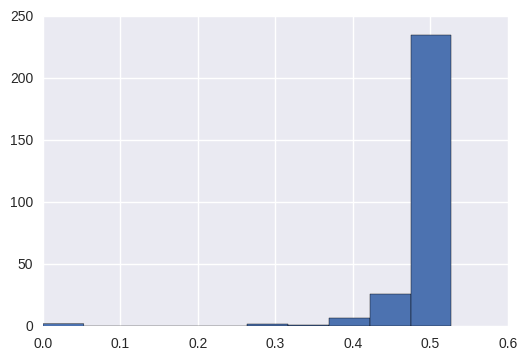

In [904]:
test_comments.groupby('from_id').agg(np.std)['prediction'].hist()

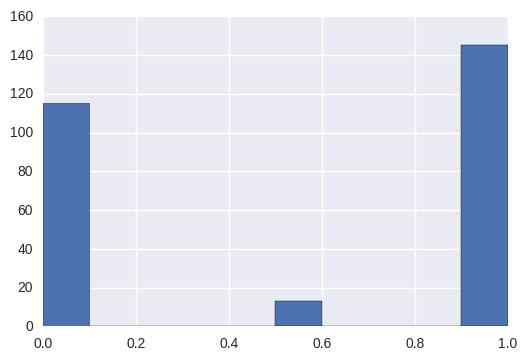

In [905]:
test_comments.groupby('from_id').agg(np.median)['prediction'].hist()